In [1]:
from qutip import *
import numpy as np
import scipy
import pybobyqa
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
class DicotomicProjector:
    def __init__(self, direction):
        sigma = [sigmax(),sigmay(),sigmaz()]
        self.dp_plus = 0.5*qeye(2)
        self.dp_minus = 0.5*qeye(2)
        for i in range(3):
            self.dp_plus += 0.5*direction[i]*sigma[i]
            self.dp_minus -= 0.5*direction[i]*sigma[i]
        self.dp = self.dp_plus - self.dp_minus #A = A^+ - A^-
        
class BellEnsemble:
    def __init__(self, p, q=0):
        #Generazione dello stato, se q=0 ho lo stato di Werner al variare di p, altrimenti ho lo stato composto
        self.p = p
        self.q = q
        bell_s = (tensor(basis(2,0),basis(2,1))-tensor(basis(2,1),basis(2,0)))/np.sqrt(2)
        bell_t = (tensor(basis(2,0),basis(2,0))+tensor(basis(2,1),basis(2,1)))/np.sqrt(2)
        self.rho = p*bell_s*bell_s.dag() + (1 - p)*(0.5*q*(bell_s*bell_s.dag() + bell_t*bell_t.dag())+(1-q)*(tensor(qeye(2),qeye(2))/4))
        
class OptimizationRun:
    def __init__(self, state, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho),
                                           method='Nelder-Mead', callback=self.displayProgress,
                                           options={'disp':True, 'maxiter':4000, 'xatol':0.0001,
                                                    'fatol':0.0001, 'adaptive':True})
    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def func_free(self, x, rho):
        #rho è la matrice densità fissata in input
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        #.real serve perche' qutip da' valore complesso in output
        return ((tensor(A0.dp,B0.dp)*rho).tr() + (tensor(A0.dp,B1.dp)*rho).tr() + (tensor(A1.dp,B0.dp)*rho).tr() - (tensor(A1.dp,B1.dp)*rho).tr()).real
    
    def displayProgress(self, xk):
        #the callback function gets only the parameters vectors as an input, the state is a class parameter
        self.history.append(self.func_free(xk, self.state.rho))
    
    def run_plot(self, flag):
        fig = plt.figure()
        graph = fig.add_subplot(111)
        graph.plot(self.history, 'r-')
        graph.set_xlabel('Iterations')
        graph.set_ylabel('CHSH Value')
        graph.set_title(f"Parameters optimization with p={self.state.p} and q={self.state.q}")
        return fig
    
class OptimizationExperimental:
    def __init__(self, state, N, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.N = N
        #self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho, self.N),
        #                                   method='Nelder-Mead',
        #                                   options={'disp':True, 'maxiter':1600, 'xatol':0.001,
        #                                            'fatol':0.01, 'adaptive':True})
        self.run = scipy.optimize.dual_annealing(self.func_free, [(0,3.14),(0,1.57),(0,3.14),(0,1.57),
                                                                  (0,3.14),(0,1.57),(0,3.14),(0,1.57)],
                                                args=(self.state.rho, self.N))
    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def exp_evaluation(self, op1, op2, rho, N):
        op1plus = op1.dp_plus
        op1minus = op1.dp_minus
        op2plus = op2.dp_plus
        op2minus = op2.dp_minus
        
        Npp = np.random.poisson(N*((tensor(op1plus,op2plus)*rho).tr()).real)
        Npm = np.random.poisson(N*((tensor(op1plus,op2minus)*rho).tr()).real)
        Nmp = np.random.poisson(N*((tensor(op1minus,op2plus)*rho).tr()).real)
        Nmm = np.random.poisson(N*((tensor(op1minus,op2minus)*rho).tr()).real)
        
        return (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
    
    def func_free(self, x, rho, N):
        #rho è la matrice densità fissata in input
        #calcolo direzioni e operatori
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        
        N00 = self.exp_evaluation(A0,B0,rho,N)
        N01 = self.exp_evaluation(A0,B1,rho,N)
        N10 = self.exp_evaluation(A1,B0,rho,N)
        N11 = self.exp_evaluation(A1,B1,rho,N)
        
        #Workaround alla funzione di callback
        #print(N00 + N01 + N10 - N11)
        self.history.append(N00 + N01 + N10 - N11)
        
        return N00 + N01 + N10 - N11

In [3]:
teststate = BellEnsemble(0.5,0.1)
testrun = OptimizationRun(teststate)
teststate.rho

Optimization terminated successfully.
         Current function value: -1.486607
         Iterations: 618
         Function evaluations: 981


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.125   0.      0.      0.0125]
 [ 0.      0.375  -0.2625  0.    ]
 [ 0.     -0.2625  0.375   0.    ]
 [ 0.0125  0.      0.      0.125 ]]

In [4]:
states = []
results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0,0.1,0.2,0.3,0.4,0.5]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationRun(teststate)
        states.append(teststate)
        results.append([testrun.run.fun,p,q])


Optimization terminated successfully.
         Current function value: -1.414213
         Iterations: 404
         Function evaluations: 652
Optimization terminated successfully.
         Current function value: -1.486607
         Iterations: 618
         Function evaluations: 981
Optimization terminated successfully.
         Current function value: -1.562050
         Iterations: 554
         Function evaluations: 879
Optimization terminated successfully.
         Current function value: -1.640122
         Iterations: 520
         Function evaluations: 823
Optimization terminated successfully.
         Current function value: -1.720465
         Iterations: 551
         Function evaluations: 872
Optimization terminated successfully.
         Current function value: -1.802775
         Iterations: 467
         Function evaluations: 747
Optimization terminated successfully.
         Current function value: -1.697056
         Iterations: 404
         Function evaluations: 652
Optimization 

<IPython.core.display.Javascript object>


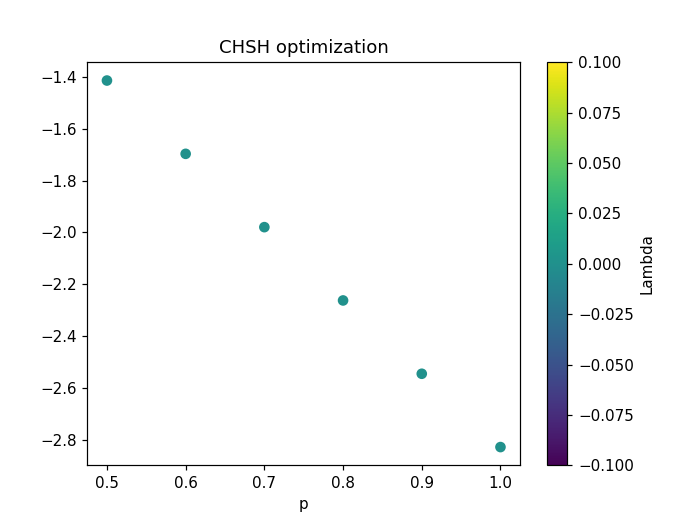

In [7]:
val = []
pval = []
qval = []
for run in results:
    val.append(run[0])
    pval.append(run[1])
    qval.append(run[2])
    #print(f"{run[0]} at p = {run[1]} and q = {run[2]}")

plt.figure()
plt.scatter(pval, val, c=qval, label=qval)
plt.title('CHSH optimization')
plt.xlabel('p')
plt.colorbar(label='Lambda')

In [6]:
#Inizia a convergere per N=10^5
state_exp = BellEnsemble(1,0)
N_exp = []
for N in [1000, 10000, 100000, 120000, 140000, 160000, 180000, 200000]:
    N_exp.append(OptimizationExperimental(state_exp, N))
    
plt.figure()
for run in N_exp:
    print(run.run.fun)
    plt.plot(run.history)

<IPython.core.display.Javascript object>

-2.910497037461776
-2.8253566829881054
-2.8428364051066124
-2.8388066150573614
-2.8386522371521914
-2.8375167333273428
-2.8360399895854482
-2.838539248491393


In [ ]:
#Experimental optimization
#MaxIter=1600 -> GROSSI PROBLEMI CON N~10^5
exp_states = []
exp_results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0,0.1,0.2,0.3,0.4,0.5]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationExperimental(teststate, 100000)
        exp_states.append(teststate)
        exp_results.append([testrun.run.fun,p,q])

In [ ]:
#Limite ottimizzazione Nelder-Mead, caso sperimentale
exp_val = []
exp_pval = []
exp_qval = []
print("Experimental Minimization")
for run in exp_results:
    exp_val.append(run[0])
    exp_pval.append(run[1])
    exp_qval.append(run[2])
    print(f"{run[0]} at p = {run[1]} and q = {run[2]}")

plt.figure()
plt.scatter(exp_pval, exp_val, c=exp_qval)
plt.title('CHSH optimization - Experimental')
plt.xlabel('p')
plt.colorbar(label='Lambda')

In [ ]:
deltas = []
for i in range(len(val)):
    deltas.append(np.abs(val[i] - exp_val[i]))
plt.figure()
plt.scatter(exp_pval, deltas, c=exp_qval, label=exp_qval)
plt.title("Delta between stochastic and exact")
plt.xlabel('p')
plt.colorbar(label='Lambda')

# Study on best optimization algorithm for our approach

Candidates:

- NelderMead -> starts to work since N ~ 10^5
- Dual Annealing - Seems it doesn't work
- Powell -> seems to work
- LBFGS
- CG
- PyBOBYQA -> not too bad, lots of function calls
- Bayesian Optimization

Nota che i problemi grossi provengono dall'introduzione del parametro lambda

Optimization terminated successfully.
         Current function value: -2.828427
         Iterations: 457
         Function evaluations: 751


<IPython.core.display.Javascript object>


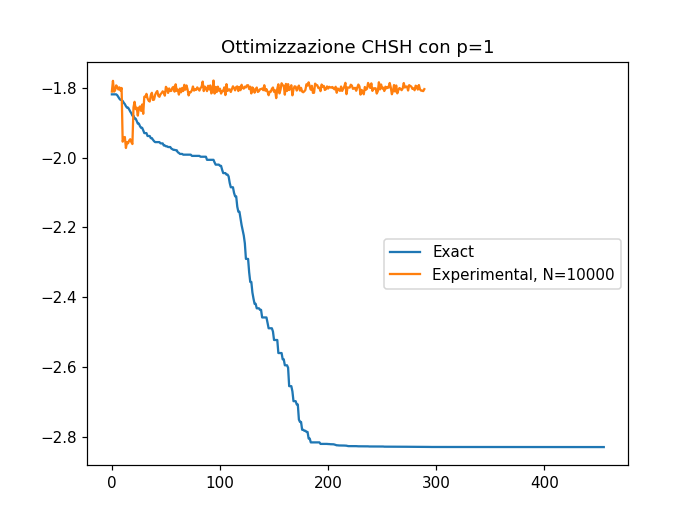

     fun: -1.8143883624289314
     jac: array([ -258403.93208601,  -460539.19838612,   380514.39197828,
        -472210.95544331,   -74096.55235742,   366211.86760892,
        1082804.21787928, -1089500.3177027 ])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 290
     nit: 2
    njev: 27
  status: 2
 success: False
       x: array([-1.99318926e-05,  1.00000181e-01,  1.99997664e-01,  2.99988517e-01,
        3.99991389e-01,  4.99996137e-01,  5.99992215e-01,  6.99998120e-01])


In [25]:
class OptimizationExperimental:
    def __init__(self, state, N, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.N = N
        #self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho, self.N),
        #                                   method='Nelder-Mead',
        #                                   options={'disp':True, 'maxiter':1600, 'xatol':0.001,
        #                                            'fatol':0.001, 'adaptive':False})
        #self.run = scipy.optimize.dual_annealing(self.func_free, [(0,3.14),(0,1.57),(0,3.14),(0,1.57),
        #                                                         (0,3.14),(0,1.57),(0,3.14),(0,1.57)],
        #                                         args=(self.state.rho, self.N))
        
        self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho, self.N),
                                          method='CG')
        
        #self.run = pybobyqa.solve(self.func_free, self.x0, objfun_has_noise=True)
        
    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def exp_evaluation(self, op1, op2, rho, N):
        op1plus = op1.dp_plus
        op1minus = op1.dp_minus
        op2plus = op2.dp_plus
        op2minus = op2.dp_minus
        
        Npp = np.random.poisson(N*((tensor(op1plus,op2plus)*rho).tr()).real)
        Npm = np.random.poisson(N*((tensor(op1plus,op2minus)*rho).tr()).real)
        Nmp = np.random.poisson(N*((tensor(op1minus,op2plus)*rho).tr()).real)
        Nmm = np.random.poisson(N*((tensor(op1minus,op2minus)*rho).tr()).real)
        
        return (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
    
    def func_free(self, x, rho=None, N=None):
        if rho is None:
            rho = self.state.rho
        if N is None:
            N = self.N
        
        #rho è la matrice densità fissata in input
        #calcolo direzioni e operatori
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        
        N00 = self.exp_evaluation(A0,B0,rho,N)
        N01 = self.exp_evaluation(A0,B1,rho,N)
        N10 = self.exp_evaluation(A1,B0,rho,N)
        N11 = self.exp_evaluation(A1,B1,rho,N)
        
        #Workaround alla funzione di callback
        #print(N00 + N01 + N10 - N11)
        self.history.append(N00 + N01 + N10 - N11)
        
        return N00 + N01 + N10 - N11

teststate = BellEnsemble(1,0)
basicrun = OptimizationRun(teststate)
exprun = OptimizationExperimental(teststate, 10000) #N~10
plt.figure()
plt.plot(basicrun.history, label='Exact')
plt.plot(exprun.history, label='Experimental, N=10000')
plt.legend()
plt.title('Ottimizzazione CHSH con p=1')
print(exprun.run)

In [26]:
states = []
results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationRun(teststate)
        states.append(teststate)
        results.append([testrun.run.fun,p,q])
exp_states = []
exp_results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationExperimental(teststate, 10000)
        exp_states.append(teststate)
        exp_results.append([testrun.run.fun,p,q])

Optimization terminated successfully.
         Current function value: -1.414214
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -1.697056
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -1.979899
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -2.262742
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -2.545584
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -2.828427
         Iterations: 457
         Function evaluations: 751


Experimental Minimization
-0.9205612256298218 at p = 0.5 and q = 0
-1.128327859443115 at p = 0.6 and q = 0
-1.275516439635622 at p = 0.7 and q = 0
-1.4544776514857927 at p = 0.8 and q = 0
-1.638228373028977 at p = 0.9 and q = 0
-1.8164019154022566 at p = 1 and q = 0


<IPython.core.display.Javascript object>


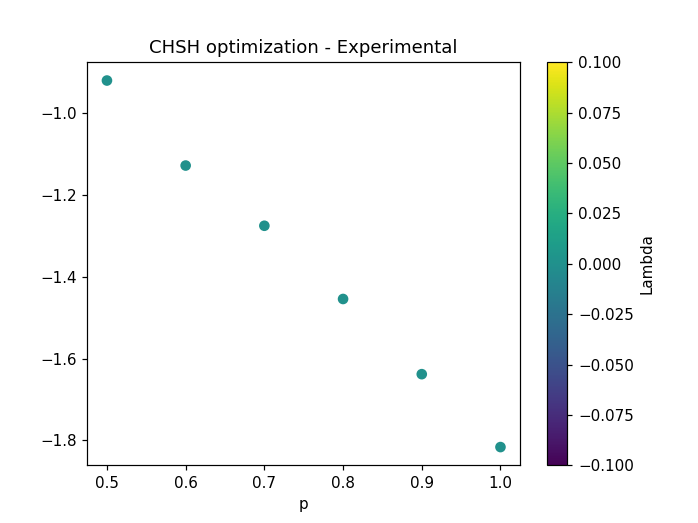

In [27]:
#Experimental minimizer
exp_val = []
exp_pval = []
exp_qval = []
exp_history = []
print("Experimental Minimization")
for run in exp_results:
    exp_val.append(run[0])
    exp_pval.append(run[1])
    exp_qval.append(run[2])
    print(f"{run[0]} at p = {run[1]} and q = {run[2]}")

plt.figure()
plt.scatter(exp_pval, exp_val, c=exp_qval)
plt.title('CHSH optimization - Experimental')
plt.xlabel('p')
plt.colorbar(label='Lambda')

<IPython.core.display.Javascript object>


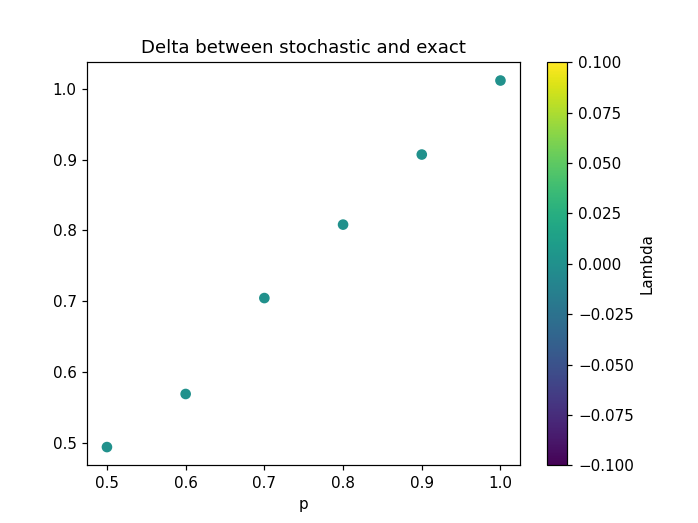

In [28]:
deltas = []
val = []
pval = []
qval = []
for run in results:
    val.append(run[0])
    pval.append(run[1])
    qval.append(run[2])
for i in range(len(val)):
    deltas.append(np.abs(val[i] - exp_val[i]))
plt.figure()
plt.scatter(exp_pval, deltas, c=exp_qval, label=exp_qval)
plt.title("Delta between stochastic and exact")
plt.xlabel('p')
plt.colorbar(label='Lambda')

In [20]:
val

[-1.4142135612605395,
 -1.6970562735126473,
 -1.979898985764755,
 -2.2627416980168635,
 -2.545584410268971,
 -2.8284271225210786]